In [1]:
pip install wikipedia

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [39]:
import wikipedia
import random
import requests 
# Set the language to English
wikipedia.set_lang("en")
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ronik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [86]:
def fetch_notable_names(limit=10):
    query = """
    SELECT ?person ?personLabel WHERE {{
      ?person wdt:P31 wd:Q5; # Instance of human
              wdt:P166 ?award.
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}

    LIMIT {}
    """.format(limit)

    
    print(query)
    
    url = 'https://query.wikidata.org/sparql'
    headers = {'User-Agent': 'Mozilla/5.0', 'Accept': 'application/json'}
    response = requests.get(url, headers=headers, params={'query': query, 'format': 'json'})
    print(response.status_code)
    
    results = response.json()['results']['bindings']
    names = [result['personLabel']['value'] for result in results]
    return names

In [107]:
# Fetch names of notable individuals
notable_names = fetch_notable_names(limit=1000)  # Adjust the limit as needed



    SELECT ?person ?personLabel WHERE {
      ?person wdt:P31 wd:Q5; # Instance of human
              wdt:P106 wd:Q639669; # Occupation musician
              wdt:P569 ?dob. # Date of birth
      FILTER((?dob >= "1901-01-01T00:00:00Z"^^xsd:dateTime) && (?dob <= "2000-12-31T23:59:59Z"^^xsd:dateTime))
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }

    LIMIT 1000
    
200


In [109]:
award_winners = []
for name in notable_names:
    page_url = None  # Initialize page_url as None

    try:
        page = wikipedia.page(name)
        page_url = page.url  # Assuming you want the URL. Adjust according to your needs.
        summary = page.summary
        
    except Exception as e: #have an error
        continue

    winner = {}
    winner['Name'] = page.title
    winner['summary'] = summary
    winner['Wikipedia Page'] = page_url
    award_winners.append(winner)

In [119]:
df = pd.DataFrame(award_winners)

,Name,summary,Wikipedia Page
0,Douglas Adams,Douglas Noel Adams (11 March 1952 – 11 May 200...,https://en.wikipedia.org/wiki/Douglas_Adams
1,Julio Bashmore,"Mathew Stephen Walker, better known by the sta...",https://en.wikipedia.org/wiki/Julio_Bashmore
2,Leonard Cohen,"Leonard Norman Cohen (September 21, 1934 – No...",https://en.wikipedia.org/wiki/Leonard_Cohen
3,Janis Joplin,"Janis Lyn Joplin (January 19, 1943 – October 4...",https://en.wikipedia.org/wiki/Janis_Joplin
4,Serge Gainsbourg,Serge Gainsbourg (French: [sɛʁʒ ɡɛ̃zbuʁ] ; bor...,https://en.wikipedia.org/wiki/Serge_Gainsbourg
...,...,...,...
707,Lou Rhodes,Lou Rhodes is an English singer and songwriter...,https://en.wikipedia.org/wiki/Lou_Rhodes
708,Giovanni Antonini,Giovanni Antonini (born 1965) is an Italian co...,https://en.wikipedia.org/wiki/Giovanni_Antonini
709,Manu Dibango,"Emmanuel N'Djoké ""Manu"" Dibango (12 December 1...",https://en.wikipedia.org/wiki/Manu_Dibango
710,Happy Rhodes,"Happy Rhodes (born Kimberley Tyler Rhodes, Aug...",https://en.wikipedia.org/wiki/Happy_Rhodes


In [7]:
df.to_csv('Final_dataSummary.csv',encoding = 'utf-8-sig', index=False)

In [189]:
file_path = 'C:\\Users\\ronik\\OneDrive - Ariel University\\Desktop\\final project ML\\Final_dataSummary.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [190]:
def prepare_data(df):
    # Initialize the Porter Stemmer
    ps = PorterStemmer()

    # Function to stem text
    def stem_text(text):
        words = word_tokenize(text)
        stemmed_words = [ps.stem(word) for word in words]
        return ' '.join(stemmed_words)
    
    # Drop the 'Wikipedia Page' column from the DataFrame

    df.drop('Wikipedia Page', axis=1, inplace=True)
    
    # Converting columns to string
    df['Name'] = df['Name'].astype(str)
    df['summary'] = df['summary'].astype(str)
    
    # Convert entire DataFrame to lowercase
    df = df.applymap(lambda x: x.lower() if type(x) == str else x)
    
    # Regular expression to match any punctuation or special character
    regex_pattern = r'[^\w\s]'
    df['Name'] = df['Name'].str.replace(regex_pattern, '', regex=True)
    df['summary'] = df['summary'].str.replace(regex_pattern, '', regex=True)
    
    # Apply the stemming function to the 'summary' column
    df['summary'] = df['summary'].apply(stem_text)
    
    # Return the modified DataFrame
    return df

In [191]:
df  = prepare_data(df)

# אם יש לי מילה שיש בה יחסית משקל מגבוה אז אני ארצה סווג לפיו

In [156]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the raw text data
tfidf_matrix = vectorizer.fit_transform(df['summary'])

In [157]:
tfidf_matrix

<718x10442 sparse matrix of type '<class 'numpy.float64'>'
	with 43704 stored elements in Compressed Sparse Row format>

In [158]:
print(tfidf_matrix.shape)

(718, 10442)


In [159]:
# Convert the tfidf_matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray())

In [160]:
tfidf_df

,0,1,2,3,4,5,6,7,8,9,...,10432,10433,10434,10435,10436,10437,10438,10439,10440,10441
0,0.0,0.0,0.0,0.0,0.0,0.0,0.092573,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
714,0.0,0.0,0.0,0.0,0.0,0.0,0.024054,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
715,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
716,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Reduce by Variance

In [161]:
from sklearn.feature_selection import VarianceThreshold

In [162]:
import numpy as np

#variance
variances = np.var(tfidf_df, axis=0)
# Calculate the mean of these variances
mean_variance = np.mean(variances)

selector = VarianceThreshold(threshold=mean_variance)

# Fitting the model and transforming the data
X_selected = selector.fit_transform(tfidf_df)

In [163]:
X_selected.shape

(718, 2712)

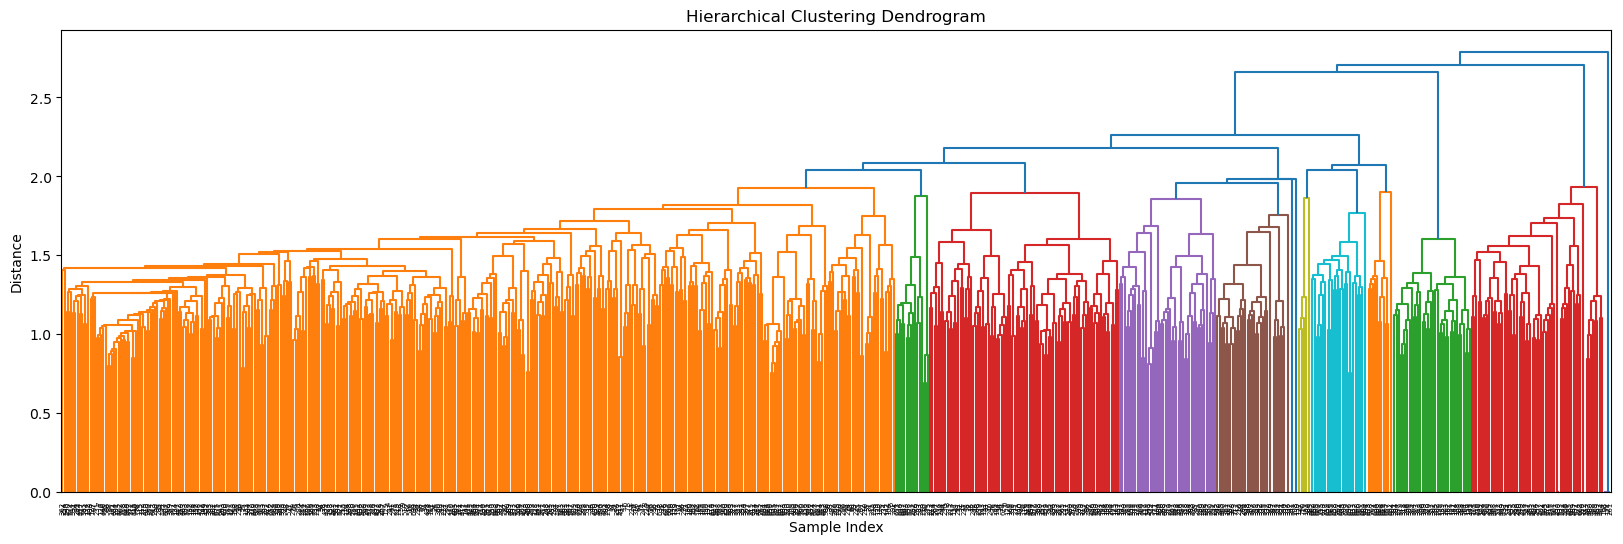

In [164]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Perform hierarchical clustering
linked = linkage(X_selected , method='ward')

# Plot the dendrogram
plt.figure(figsize=(20, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

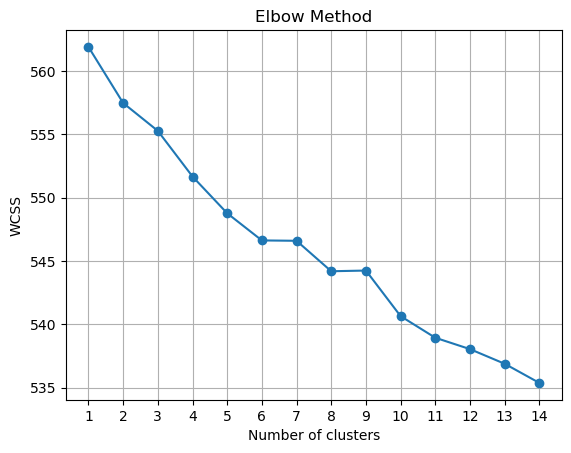

In [165]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


# Calculate the within-cluster sum of squares (WCSS) for different values of K
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_selected)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 15))
plt.grid(True)
plt.show()

# Reduce by TruncatedSVD

In [166]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

# Let's pretend tfidf_matrix is your big table with 10,442 columns
# First, we're not sure how many new columns we need, so we start with a guess

# Step 1: Set up SVD with a guess of 300 new columns
svd = TruncatedSVD(n_components=min(1000, tfidf_matrix.shape[1]-1)) # 600 is just a starting guess

# Step 2: Apply SVD to your big table
svd.fit(tfidf_matrix)  # This learns the new columns

# Step 3: Check how much information (variance) these 300 columns give us
cumulative_info = np.cumsum(svd.explained_variance_ratio_)

# Step 4: Find out how many of these 300 columns we need to reach 85% info
n_columns_for_85 = np.argmax(cumulative_info >= 0.85) + 1  # +1 because counting starts at 0

# Now, n_columns_for_85 tells us how many columns are needed to keep 85% info
print("Number of columns needed:", n_columns_for_85)
 #Reduce the data again with the selected number of components
svd_85 = TruncatedSVD(n_components=n_columns_for_85)
X_reduced_85 = svd_85.fit_transform(tfidf_matrix)


Number of columns needed: 505


# hierarchical Model

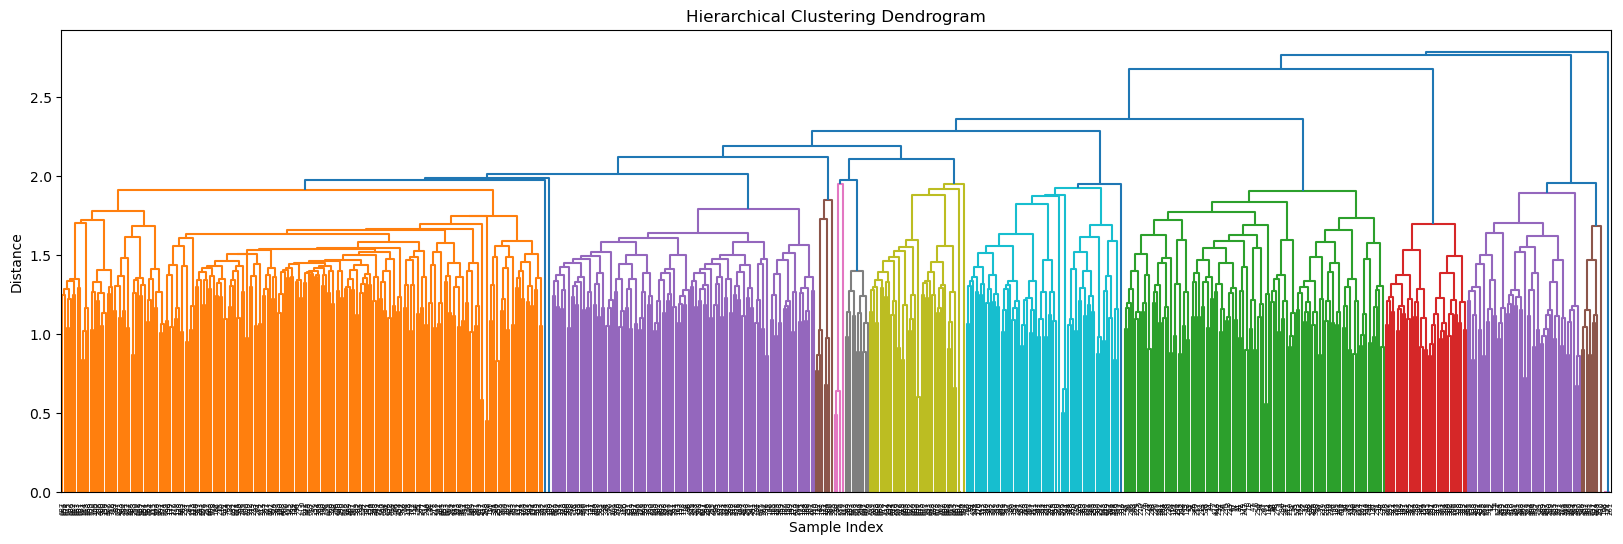

In [167]:
from scipy.cluster.hierarchy import dendrogram, linkage
# Perform hierarchical clustering
linked = linkage(df_reduced_85, method='ward')

# Plot the dendrogram
plt.figure(figsize=(20, 6))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [141]:
# Perform hierarchical clustering

from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clustering.fit_predict(df_reduced_85)



# K-means Model

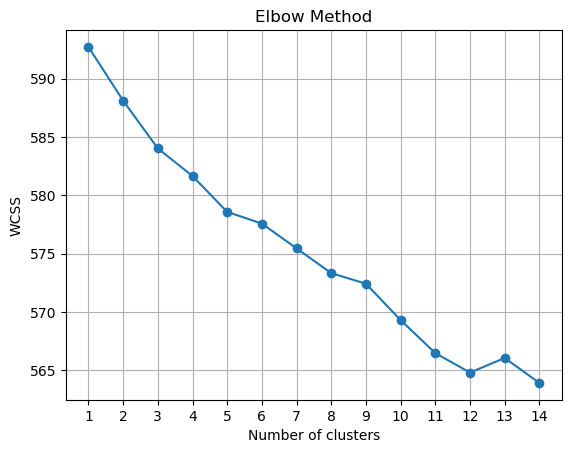

In [168]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


# Calculate the within-cluster sum of squares (WCSS) for different values of K
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_reduced_85)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method graph
plt.plot(range(1, 15), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range(1, 15))
plt.grid(True)
plt.show()

# Models Together

In [174]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import numpy as np


feature_selection_methods = [
    ('variance_threshold', VarianceThreshold(mean_variance)),
    ('SVD', TruncatedSVD(n_components=n_columns_for_85)),
    ('original_features', None)  # Indicating no selection/transformation
]

# Note: Not directly including clustering models in the loop anymore since
# the number of clusters might change based on the feature selection method
clustering_method_names = ['KMeans', 'hierarchical']


for method_name, method in feature_selection_methods:
    for clustering_method_name in clustering_method_names:
        
        # Dynamically adjust the number of clusters for KMeans based on the feature selection method
        if method_name == 'variance_threshold' and clustering_method_name == 'KMeans':
            model = KMeans(n_clusters=8, init='k-means++', max_iter=300, n_init=10, random_state=0)
        elif clustering_method_name == 'KMeans':
            model = KMeans(n_clusters=12, init='k-means++', max_iter=300, n_init=10, random_state=0)
        else:
            model = AgglomerativeClustering(n_clusters=10)
        
        if method_name == 'original_features':
            X_transformed = tfidf_df  # No transformation
        else:
            # Apply transformation outside of pipeline for clarity
            transformer = method
            X_transformed = transformer.fit_transform(tfidf_df) if method else tfidf_df

        # Apply the clustering model directly to the transformed data
        cluster_labels = model.fit_predict(X_transformed)

        # Compute evaluation metrics
        silhouette = silhouette_score(X_transformed, cluster_labels)
        davies_bouldin = davies_bouldin_score(X_transformed, cluster_labels)
        calinski_harabasz = calinski_harabasz_score(X_transformed, cluster_labels)

        print(f"Feature Selection Method: {method_name}, Clustering Model: {clustering_method_name}")
        print(f"Silhouette Score: {silhouette}")
        print(f"Davies–Bouldin Index: {davies_bouldin}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz}\n")

        # Print cluster counts
        cluster_counts = np.bincount(cluster_labels, minlength=model.n_clusters if hasattr(model, 'n_clusters') else np.max(cluster_labels) + 1)
        print(f"Cluster Counts for {clustering_method_name} with {method_name}: {cluster_counts}\n")
        
        


Feature Selection Method: variance_threshold, Clustering Model: KMeans
Silhouette Score: -0.001550161856743562
Davies–Bouldin Index: 6.038740471695883
Calinski-Harabasz Index: 3.3027574494923275

Cluster Counts for KMeans with variance_threshold: [  1  75 109 117  23   4  15 374]

Feature Selection Method: variance_threshold, Clustering Model: hierarchical
Silhouette Score: 0.006252220287418407
Davies–Bouldin Index: 5.9252810233001245
Calinski-Harabasz Index: 3.5884659552661855

Cluster Counts for hierarchical with variance_threshold: [ 83  12  61   6  16 386  88   4  26  36]

Feature Selection Method: SVD, Clustering Model: KMeans
Silhouette Score: 0.00043773910056359486
Davies–Bouldin Index: 6.084307145583928
Calinski-Harabasz Index: 3.024882259261259

Cluster Counts for KMeans with SVD: [ 17  52  90  30   8  29  55  26  82 322   4   3]

Feature Selection Method: SVD, Clustering Model: hierarchical
Silhouette Score: 0.0003856303501272568
Davies–Bouldin Index: 6.872116421314968
Calins

# The best score is Feature Selection Method: variance threshold, Clustering Model: hierarchical

In [93]:
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clustering.fit_predict(X_selected)

In [95]:
# and 'agg_labels' are the labels obtained from AgglomerativeClustering
df['Cluster'] = agg_labels
df

,Name,summary,Cluster
0,antonio arias bernal,antonio aria bernal also known as the brigadi ...,6
1,austregésilo de athayde,austregésilo de athayd septemb 25 1898 septemb...,5
2,jorge délano frederick,jorg délano frederick decemb 4 1895 juli 9 198...,5
3,jules dubois,jule duboi 31 march 1910 new york citi 15 augu...,6
4,carlos ramírez macgregor,carlo ramírez macgregor 3 march 1903 in maraca...,5
...,...,...,...
713,bodil award for best actress in a leading role,the bodil award for best actress in a lead rol...,0
714,rudolf hess,rudolf walter richard hess heß in german 26 ap...,5
715,carl adolph von plessen,carl adolph von plessen 18 may 1678 30 januari...,8
716,salomo sachs,salomo sach hebrew זקס שלמה roman šəlomoh sach...,5


In [99]:
for cluster in sorted(df['Cluster'].unique()):
    # Assuming 'Title' is a column in your DataFrame with the title of each Wikipedia page
    titles = df[df['Cluster'] == cluster]['Name']
    print(f"Cluster {cluster} titles:")
    print(titles.head())  # Prints the first few titles in each cluster
    print("\n")

Cluster 0 titles:
85                 cara dillon
89               terence rigby
100             rafael herrera
104    timothy johnson fighter
108                  paul knox
Name: Name, dtype: object


Cluster 1 titles:
604            kaj birksted
619             peder anker
628               otto ruge
634          niels treschow
657    hilmar meincke krohg
Name: Name, dtype: object


Cluster 2 titles:
29     john moors cabot
105       james l jones
112     william tolbert
172     michael longley
246          david vela
Name: Name, dtype: object


Cluster 3 titles:
42       carlos branco
122     roberto müller
193     viktor burakov
385    stephen hawkins
386    stephen hawkins
Name: Name, dtype: object


Cluster 4 titles:
13                 yoani sánchez
80     francisco santos calderón
219           juan manuel santos
269                pedro sánchez
275                santos family
Name: Name, dtype: object


Cluster 5 titles:
1     austregésilo de athayde
2      jorge délano frederi